# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [225]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

In [226]:
df_raw = pd.read_csv("../assets/admissions.csv")
df = df_raw.dropna() 
print df.sort_values(by='gre', ascending=False).head()

     admit    gre   gpa  prestige
25       1  800.0  3.66       1.0
18       0  800.0  3.75       2.0
245      0  800.0  3.91       3.0
150      1  800.0  3.74       1.0
69       0  800.0  3.73       1.0


In [227]:
df.gre.value_counts().head()

620.0    30
580.0    28
540.0    27
800.0    25
520.0    24
Name: gre, dtype: int64

In [228]:
df['gre'].unique()

array([ 380.,  660.,  800.,  640.,  520.,  760.,  560.,  400.,  540.,
        700.,  440.,  480.,  780.,  360.,  500.,  600.,  680.,  620.,
        580.,  460.,  740.,  300.,  720.,  340.,  420.,  220.])

In [229]:
df.gre.nunique() # the number of unique values in this series

26

## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [230]:
# frequency table for prestige and whether or not someone was admitted
pd.crosstab(index=df["admit"],  # Make a crosstab
                      columns=df["prestige"])      # Name the count column

prestige,1.0,2.0,3.0,4.0
admit,,,,
0,28,95,93,55
1,33,53,28,12


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [231]:
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
dummy_ranks.head()

,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0


#### 2.2 When modeling our class variables, how many do we need? 



Answer: 3 out of 4.

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [232]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1':])
print handCalc.head()

   admit    gre   gpa  prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61           0.0           0.0           1.0           0.0
1      1  660.0  3.67           0.0           0.0           1.0           0.0
2      1  800.0  4.00           1.0           0.0           0.0           0.0
3      1  640.0  3.19           0.0           0.0           0.0           1.0
4      0  520.0  2.93           0.0           0.0           0.0           1.0


In [233]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
admit_prestige_1 = pd.crosstab(handCalc['admit'], handCalc['prestige_1.0'])
admit_prestige_1

prestige_1.0,0.0,1.0
admit,,
0,243,28
1,93,33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [234]:
hand = pd.crosstab(handCalc['admit'], handCalc['prestige_1.0'])
hand

prestige_1.0,0.0,1.0
admit,,
0,243,28
1,93,33


In [235]:
sum(hand[0])

336

In [236]:
prestige_1 = (hand.loc[1,1]/float(sum(hand[1])))
prestige_1

0.54098360655737709

#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [237]:
prestige_0 = (hand.loc[1,0]/float(sum(hand[0])))
prestige_0

0.2767857142857143

#### 3.3 Calculate the odds ratio

In [238]:
p_prestige_1 = prestige_1/(1-prestige_1)
p_prestige_0 = prestige_0/(1-prestige_0)
odds_r = p_prestige_1/p_prestige_0
odds_r

3.0794930875576041

#### 3.4 Write this finding in a sentenance: 

Answer: Applicants from prestige_1 colleges are 3.08 times more likely to be admitted

#### 3.5 Print the cross tab for prestige_4

In [239]:
c4 = pd.crosstab(handCalc['admit'], handCalc['prestige_4.0'])
c4

prestige_4.0,0.0,1.0
admit,,
0,216,55
1,114,12


#### 3.6 Calculate the OR 

In [240]:
prestige_4 = (c4.loc[1,1]/float(sum(c4[1])))
prestige_not_4 = (c4.loc[1,0]/float(sum(c4[0])))
p_prestige_4 = prestige_4/(1-prestige_4)
p_prestige_not_4 = prestige_not_4/(1-prestige_not_4)
odds_r_p4 = p_prestige_4/p_prestige_not_4
odds_r_p4

0.41339712918660282

#### 3.7 Write this finding in a sentence

Answer:applicants from prestige_4 colleges are far less likely to be admitted than prestige_1,_2 or _3 colleges

## Part 4. Analysis

In [241]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2.0':])
print data.head()

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61           0.0           1.0           0.0
1      1  660.0  3.67           0.0           1.0           0.0
2      1  800.0  4.00           0.0           0.0           0.0
3      1  640.0  3.19           0.0           0.0           1.0
4      0  520.0  2.93           0.0           0.0           1.0


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [242]:
# manually add the intercept
data['intercept'] = 1.0
# would this always be true, or only in statsmodel?

#### 4.1 Set the covariates to a variable called train_cols

In [243]:
train_cols = ['gpa', 'prestige_2.0']

#### 4.2 Fit the model

In [244]:
y = data['admit']

model = sm.Logit(y, data[train_cols])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.631281
         Iterations 5


#### 4.3 Print the summary results

In [245]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      395
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Dec 2016   Pseudo R-squ.:                -0.01024
Time:                        14:01:57   Log-Likelihood:                -250.62
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
gpa             -0.2335      0.040     -5.844      0.000        -0.312    -0.155
prestige_2.0     0.2015      0.218      0.925      0.355        -0.225     0.628


In [246]:
print result.summary2()

                        Results: Logit
Model:              Logit            Pseudo R-squared: -0.010  
Dependent Variable: admit            AIC:              505.2369
Date:               2016-12-19 14:01 BIC:              513.2048
No. Observations:   397              Log-Likelihood:   -250.62 
Df Model:           1                LL-Null:          -248.08 
Df Residuals:       395              LLR p-value:      1.0000  
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
gpa             -0.2335   0.0399 -5.8443 0.0000 -0.3118 -0.1552
prestige_2.0     0.2015   0.2178  0.9252 0.3548 -0.2254  0.6284



#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [247]:
result.params?

In [248]:
np.exp(result.params)

gpa             0.791779
prestige_2.0    1.223275
dtype: float64

In [249]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
np.exp(conf)

,2.5%,97.5%,OR
gpa,0.732149,0.856266,0.791779
prestige_2.0,0.798212,1.874692,1.223275


#### 4.5 Interpret the OR of Prestige_2

Answer: This tells you how a 1 unit increase or decrease in prestige_2 affects the odds of being admitted.

The OR of prestige_2 is less than half that of prestige_1 

#### 4.6 Interpret the OR of GPA

Answer: The OR of gpa is 0.79, meaning that is is not very important for admit decision

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [ ]:
##  I am confused by this:
### if we create the range of values for gre and gpa, then how would
### they still correlate with the admit?
### 

In [267]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype #?? says list object has no attribute dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [268]:
arrays = (([1, 2, 3], [4, 5], [6, 7]))
print [np.asarray(x) for x in arrays]
#print arrays[0].dtype()
#print arrays[0].size()

[array([1, 2, 3]), array([4, 5]), array([6, 7])]


In [269]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


In [270]:
print combos.tail()
print combos.columns

         0         1    2    3
395  800.0  3.806667  4.0  1.0
396  800.0  4.000000  1.0  1.0
397  800.0  4.000000  2.0  1.0
398  800.0  4.000000  3.0  1.0
399  800.0  4.000000  4.0  1.0
RangeIndex(start=0, stop=4, step=1)


In [271]:
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
combos.columns

Index([u'gre', u'gpa', u'prestige', u'intercept'], dtype='object')

#### 5.1 Recreate the dummy variables

In [272]:
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1.0', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0']
dummy_ranks.head()

,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0


In [273]:
# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2.0':])
combos.head()

,gre,gpa,prestige,intercept,prestige_2.0,prestige_3.0,prestige_4.0
0,220.0,2.260000,1.0,1.0,0.0,0.0,0.0
1,220.0,2.260000,2.0,1.0,1.0,0.0,0.0
2,220.0,2.260000,3.0,1.0,0.0,1.0,0.0
3,220.0,2.260000,4.0,1.0,0.0,0.0,1.0
4,220.0,2.453333,1.0,1.0,0.0,0.0,0.0


#### 5.2 Make predictions on the enumerated dataset

In [274]:
combos['admit_pred'] = result.predict(combos[train_cols])

In [275]:
features = ['gre', 'gpa', 'prestige', 'admit_pred']
print combos[features].head()
print combos[features].tail()

     gre       gpa  prestige  admit_pred
0  220.0  2.260000       1.0    0.371065
1  220.0  2.260000       2.0    0.419185
2  220.0  2.260000       3.0    0.371065
3  220.0  2.260000       4.0    0.371065
4  220.0  2.453333       1.0    0.360594
       gre       gpa  prestige  admit_pred
395  800.0  3.806667       4.0    0.291367
396  800.0  4.000000       1.0    0.282136
397  800.0  4.000000       2.0    0.324677
398  800.0  4.000000       3.0    0.282136
399  800.0  4.000000       4.0    0.282136


In [287]:
grouped = pd.pivot_table(combos, values=['admit_pred'], index=[combos.gre, 'prestige'],
                            aggfunc=np.mean)
grouped.head()

admit_pred
gre        prestige            
220.000000 1.0         0.325668
           2.0         0.371199
           3.0         0.325668
           4.0         0.325668
284.444444 1.0         0.325668

#### 5.3 Interpret findings for the last 4 observations

Answer: This predicts the odds of admit for the range of gre, gpa and prestige

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

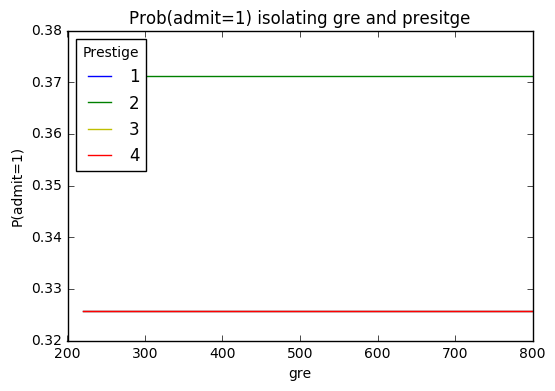

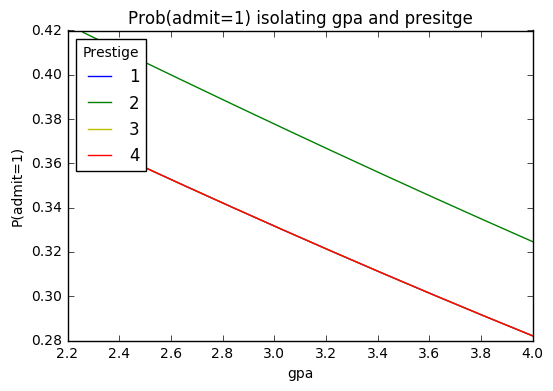

In [299]:
def isolate_and_plot(variable):
    # isolate gre and class rank
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable, 'prestige'],
                            aggfunc=np.mean)
    
    # make a plot
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'], color=colors[int(col)])

    pl.xlabel(variable)
    pl.ylabel("P(admit=1)")
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    pl.title("Prob(admit=1) isolating " + variable + " and presitge")
    pl.show()

isolate_and_plot('gre')
isolate_and_plot('gpa')
